In [98]:
import json, os
import numpy as np
from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


class Skeleton:

    gt_labels = {
        "Nose"          : np.array([0], dtype=int),
        "LEye"          : np.array([1], dtype=int),
        "REye"          : np.array([2], dtype=int),
        "LEar"          : np.array([3], dtype=int),
        "REar"          : np.array([4], dtype=int),
        "LShoulder"     : np.array([5], dtype=int),
        "RShoulder"     : np.array([6], dtype=int),
        "LElbow"        : np.array([7], dtype=int),
        "RElbow"        : np.array([8], dtype=int),
        "LWrist"        : np.array([9], dtype=int),
        "RWrist"        : np.array([10], dtype=int),
        "LHip"          : np.array([11], dtype=int),
        "RHip"          : np.array([12], dtype=int),
        "LKnee"         : np.array([13], dtype=int),
        "RKnee"         : np.array([14], dtype=int),
        "LAnkle"        : np.array([15], dtype=int),
        "RAnkle"        : np.array([16], dtype=int),
    }

    JOINT_LENGTH = {
        ("Knee", "Ankle")        : 0.0,
        ("Hip", "Knee")          : 0.0,
        ("Shoulder", "Hip")      : 0.0,
        ('Shoulder', 'Elbow')    : 0.0,
        ('Shoulder', 'Shoulder')    : 0.0,
        ('Elbow', 'Wrist')       : 0.0,
    }
    
        # @TODO : scatter plot x,y values are unnormalized... Normalize datapoints before operating
    def __init__(self, arr, preds, V_HEIGHT=720, V_WIDTH=1080 ):
            raw_input = np.array(arr).reshape(-1, 3)
            self.V_HEIGHT = V_HEIGHT
            self.V_WIDTH = V_HEIGHT
            self.preds = preds
            self.max_dist = self.get_max_dist(preds)
            self.dir_facing = self.reject_outliers(self.get_dir_facing(preds), 2).mean() - (np.pi / 2)

            temporal_feat_dict = []
            for i, pred in enumerate(preds):
                raw_input = np.array(pred['keypoints']).reshape(-1, 3)
                
                single_feat_dict = {k : ( self.process_feat(raw_input[v.item()]) )  for (k, v) in self.gt_labels.items()}
                single_feat_dict = {k : v for (k, v) in single_feat_dict.items() }
                single_feat_dict = self.add_centroids(single_feat_dict)
                temporal_feat_dict.append(single_feat_dict)
            self.feat_dict = temporal_feat_dict

            temporal_angle_dict = []
            for i, pred in enumerate(preds):
                single_angle_dict = self.add_angles(single_feat_dict, i)
                temporal_angle_dict.append(single_angle_dict)
            self.angle_dict = temporal_angle_dict

            z_feat_dict = [] 
            for i, v in enumerate(self.feat_dict):
                z_feat = self.to3D(i)
                z_feat_dict.append(z_feat)
            self.z_feat_dict = z_feat_dict

    def get_max_dist(self, preds, average=True):
        max_dist = defaultdict(float)
        for pred in map(lambda x: np.array(x['keypoints']).reshape(-1, 3), preds):
                feat_dict = {k : self.process_feat( pred[v.item()] )  for (k, v) in self.gt_labels.items()}
                for key in ['Hip', 'Ankle', 'Knee', 'Shoulder', 'Wrist']:
                        feat_dict[f"C{key}"] = (feat_dict[f"L{key}"] + feat_dict[f"R{key}"]) / 2
                
                for dir in ['L', 'R']:
                        for (j1, j2) in list(self.JOINT_LENGTH.keys()): # [(j1, j2) for j1 in list_of_joints for j2 in list_of_joints if j1 != j2]: # 
                                max_dist[(dir, j1, j2)] = max(max_dist[(dir, j1, j2)], self.joint_len(feat_dict, dir, j1, j2) )
                
                x1, y1, _ = feat_dict["RShoulder"]
                x2, y2, _ = feat_dict["LShoulder"]
                ssd = self.edist(x1, y1, x2, y2)
                max_dist[('C', "Shoulder", "Shoulder")] = max(max_dist[('C', "Shoulder", "Shoulder")], ssd)
        
        max_dist = dict(max_dist)
        if not average:
                return max_dist
        d = dict()
        for (j1, j2) in list(self.JOINT_LENGTH.keys()): # [(j1, j2) for j1 in list_of_joints for j2 in list_of_joints if j1 != j2]: # 
                d[(j1, j2)] = max(max_dist[("L", j1, j2)], max_dist[("R", j1, j2)])
        
        d[("Shoulder", "Shoulder")] = max_dist[('C', "Shoulder", "Shoulder")]
        return d

    def joint_len(self, d, dir, j1, j2):
        x1, y1, _ = d[dir + j1]
        x2, y2, _ = d[dir + j2]
        return self.edist(x1, y1, x2, y2)

    def get_dir_facing(self, preds):
        max_joint_length = self.get_max_dist(preds, average=False)
        process = lambda arr : [arr[0] / self.V_WIDTH, abs(self.V_HEIGHT - arr[1]) / self.V_HEIGHT, arr[2]]
        list_of_joints = list({ x[1:]  for x in self.gt_labels.keys() if (x[0] in ['L', 'R']) })
        zs = list()
        for i in range(len(preds)):
                raw_input = np.array(preds[i]['keypoints']).reshape(-1, 3)
                feat_dict = {k : (process(raw_input[v.item()]) )  for (k, v) in self.gt_labels.items()}
                x1, y1, _ = feat_dict['L' + "Hip"]
                x2, y2, _ = feat_dict['L' + "Knee"]
                projHipKnee = self.edist(x1, y1, x2, y2)
                trueHipKnee = max_joint_length[("L", "Hip", "Knee")]
                zDist = ((trueHipKnee**2) - (projHipKnee**2))**0.5
                theta1 = np.arctan((zDist) / (projHipKnee))

                x1, y1, _ = feat_dict['R' + "Hip"]
                x2, y2, _ = feat_dict['R' + "Knee"]
                projHipKnee = self.edist(x1, y1, x2, y2)
                trueHipKnee = max_joint_length[("R", "Hip", "Knee")]
                zDist = ((trueHipKnee**2) - (projHipKnee**2))**0.5
                theta2 = np.arctan((zDist) / (projHipKnee))

                zs.append(((theta1 + theta2) / 2))

        zs = np.array(zs)

        return zs

    def reject_outliers(self, data, m = 4.):
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]

    def cosine_law(self, a, b, c):
            """ Calculate angle opposite `c`"""
            theta = np.arccos(((a**2) + (b**2) - (c**2)) / (2 * a * b))
            return theta

    def add_centroids(self, d):
            for key in ['Hip', 'Ankle', 'Knee', 'Shoulder', 'Wrist']:
                    d[f"C{key}"] = (d[f"L{key}"] + d[f"R{key}"]) / 2
            return d
    
    def calc_z_val(self, x1, y1, x2, y2, xx, yy):
            proj_length = np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
            true_length = self.max_dist[(xx, yy)]
            return -1 * ((true_length ** 2) - (proj_length ** 2)) ** 0.5
            
    def calc_gamma(self, x1, y1, x2, y2, xx, yy):
            proj_length = np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
            true_length = self.max_dist[(xx, yy)]
            return (np.arccos(proj_length / true_length))
            # return 0

    def plot_animated(self, plot_3d=False, angle=None):
            
        frames = [] # for storing the generated images
        fig = plt.figure(figsize=(10, 10))
        if plot_3d:
                ax = fig.add_subplot(111, projection='3d')
        else:
                ax = fig.add_subplot(111)

        ax.set_ylim([0, 1])
        ax.set_xlim([0.5, 1.5])

        for i, v in enumerate(self.feat_dict):
            for dir in ['L', 'R']:
                for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee'), ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]: # ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')
                        x1, y1, _ = (v[dir+xx])
                        x2, y2, _ = (v[dir+yy])
                                                # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                                                # gamma = self.calc_gamma(x1, y1, x2, y2, xx, yy)
                                                # y1 = abs(7.20 - y1)
                                                # y2 = abs(7.20 - y2)
                        print("1" , [x1, x2], [y1, y2], dir+xx+yy + str(np.degrees(self.angle_dict[i][(dir, xx, yy)])), dir+xx, dir+yy)
                        ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label=dir+xx+yy + str(np.degrees(self.angle_dict[i][(dir, xx, yy)])))

            x1, y1, _ = (v["CHip"])
            x2, y2, _ = (v["CShoulder"])
            # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
            # y1 = abs(7.20 - y1)
            # y2 = abs(7.20 - y2)
            ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="Spine" + str(np.degrees( self.angle_dict[i][("C", "Spine")] )))
            gamma = self.dir_facing
            x1, y1, _ = v["CAnkle"]
            x2 = x1 + (2 * np.cos(gamma))
            y2 = y1 + (2 * np.sin(gamma))
            print("2" , [x1, x2], [y1, y2], "FacingDir" + str(np.degrees(gamma) ))
            ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="FacingDir" + str(np.degrees(gamma) ))

            for (xx, yy) in [('Hip', 'Hip'), ('Shoulder', 'Shoulder')]:
                    x1, y1, _ = (v["L"+xx])
                    x2, y2, _ = (v["R"+yy])
                    # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                    # y1 = abs(7.20 - y1)
                    # y2 = abs(7.20 - y2)
                    print("3" , [x1, x2], [y1, y2], "RL" + xx)
                    ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="RL" + xx)

            ax.legend()
            frames.append([ax.imshow(animated=True)])

        ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        # ani.save('movie.mp4')
        fig.show()

        return

# 1 [0.9164305792914497, 0.9164305792914497] [0.47254791259765627, 0.34483913845486114] LKneeAnkle0.0
# 1 [0.8591818067762587, 0.9164305792914497] [0.5606229146321614, 0.47254791259765627] LHipKnee-21.423622248974343
# 1 [0.9868905809190538, 0.9912943522135417] [0.5474116855197483, 0.4637404123942057] LShoulderElbow0.0
# 1 [0.9912943522135417, 0.9868905809190538] [0.4637404123942057, 0.3932804107666016] LElbowWrist0.0
# 1 [0.8063368055555555, 0.7975293477376302] [0.4637404123942057, 0.3184166378445096] RKneeAnkle0.0
# 1 [0.7843180338541667, 0.8063368055555555] [0.5738341861300998, 0.4637404123942057] RHipKnee-9.04806479961334
# 1 [0.8988155788845487, 0.8503743489583333] [0.5430079142252604, 0.4593366410997179] RShoulderElbow0.0
# 1 [0.8503743489583333, 0.8239518059624567] [0.4593366410997179, 0.36245413886176214] RElbowWrist0.0
# 2 [0.8569799635145399, 2.0642761238882423] [0.33162788814968536, -1.262873909010454] FacingDir-52.8683786202506
# 3 [0.8591818067762587, 0.7843180338541667] [0.5606229146321614, 0.5738341861300998] RLHip
# 3 [0.9868905809190538, 0.8988155788845487] [0.5474116855197483, 0.5430079142252604] RLShoulder

    def animate(self, i):
            for dir in ['L', 'R']:
                for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee'), ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]: # ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')
                        x1, y1, _ = (self.feat_dict[i][dir+xx])
                        x2, y2, _ = (self.feat_dict[i][dir+yy])
                p1.set xdata()
                        ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label=dir+xx+yy + str(np.degrees(self.angle_dict[i][(dir, xx, yy)])))

            x1, y1, _ = (v["CHip"])
            x2, y2, _ = (v["CShoulder"])
            # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
            # y1 = abs(7.20 - y1)
            # y2 = abs(7.20 - y2)
            ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="Spine" + str(np.degrees( self.angle_dict[i][("C", "Spine")] )))
            gamma = self.dir_facing
            x1, y1, _ = v["CAnkle"]
            x2 = x1 + (2 * np.cos(gamma))
            y2 = y1 + (2 * np.sin(gamma))
            print("2" , [x1, x2], [y1, y2], "FacingDir" + str(np.degrees(gamma) ))
            ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="FacingDir" + str(np.degrees(gamma) ))

            for (xx, yy) in [('Hip', 'Hip'), ('Shoulder', 'Shoulder')]:
                    x1, y1, _ = (v["L"+xx])
                    x2, y2, _ = (v["R"+yy])
                    # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                    # y1 = abs(7.20 - y1)
                    # y2 = abs(7.20 - y2)
                    print("3" , [x1, x2], [y1, y2], "RL" + xx)
                    ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="RL" + xx)

            ax.legend()
        
        
    
    def plot(self, frame, plot_3d=False, save_loc=None, angle=None):
            fig = plt.figure(figsize=(10, 10))
            if plot_3d:
                    ax = fig.add_subplot(111, projection='3d')
            else:
                    ax = fig.add_subplot(111)
            ax.set_ylim([0, 1])
            ax.set_xlim([0.5, 1.5])
            
            if plot_3d:
                    ax.set_xlim([0, 1])
                    ax.set_zlim([0, 1])
                    ax.set_ylim([-1, 1])
                    ax.view_init(azim=45, elev=5)
                    if angle:
                            ax.view_init(azim=angle, elev=5)
           
                    for dir in ['L', 'R']:
                            for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee'), ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]: # ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')
                                    x1, y1, z1 = (self.z_feat_dict[frame][dir+xx])
                                    x2, y2, z2 = (self.z_feat_dict[frame][dir+yy])
                                    # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                                    # gamma = self.calc_gamma(x1, y1, x2, y2, xx, yy)
                                    # y1 = abs(7.20 - y1)
                                    # y2 = abs(7.20 - y2)
                                    ax.plot(xs=[x1, x2], ys=[z1, z2], zs=[y1, y2],  linewidth=1.2, label=dir+xx+yy)

                    x1, y1, z1 = (self.z_feat_dict[frame]["CHip"])
                    x2, y2, z2 = (self.z_feat_dict[frame]["CShoulder"])
                    # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                    # y1 = abs(7.20 - y1)
                    # y2 = abs(7.20 - y2)
                    ax.plot(xs=[x1, x2], ys=[z1, z2], zs=[y1, y2],  linewidth=1.2, label="Spine")

                    for (xx, yy) in [('Hip', 'Hip'), ('Shoulder', 'Shoulder')]:
                            x1, y1, z1 = (self.z_feat_dict[frame]["L"+xx])
                            x2, y2, z2 = (self.z_feat_dict[frame]["R"+yy])
                            # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                            # y1 = abs(7.20 - y1)
                            # y2 = abs(7.20 - y2)
                            ax.plot(xs=[x1, x2], ys=[z1, z2], zs=[y1, y2],  linewidth=1.2, label="RL" + xx)
                    if save_loc:
                            fig.savefig(save_loc)
                    return
            

            for dir in ['L', 'R']:
                    for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee'), ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]: # ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')
                            x1, y1, _ = (self.feat_dict[frame][dir+xx])
                            x2, y2, _ = (self.feat_dict[frame][dir+yy])
                            # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                            # gamma = self.calc_gamma(x1, y1, x2, y2, xx, yy)
                            # y1 = abs(7.20 - y1)
                            # y2 = abs(7.20 - y2)
                            ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label=dir+xx+yy + str(np.degrees(self.angle_dict[frame][(dir, xx, yy)])))

            x1, y1, _ = (self.feat_dict[frame]["CHip"])
            x2, y2, _ = (self.feat_dict[frame]["CShoulder"])
            # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
            # y1 = abs(7.20 - y1)
            # y2 = abs(7.20 - y2)
            ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="Spine" + str(np.degrees( self.angle_dict[frame][("C", "Spine")] )))
            gamma = self.dir_facing
            x1, y1, _ = self.feat_dict[frame]["CAnkle"]
            x2 = x1 + (2 * np.cos(gamma))
            y2 = y1 + (2 * np.sin(gamma))
            ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="FacingDir" + str(np.degrees(gamma) ))

            for (xx, yy) in [('Hip', 'Hip'), ('Shoulder', 'Shoulder')]:
                    x1, y1, _ = (self.feat_dict[frame]["L"+xx])
                    x2, y2, _ = (self.feat_dict[frame]["R"+yy])
                    # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                    # y1 = abs(7.20 - y1)
                    # y2 = abs(7.20 - y2)
                    ax.plot([x1, x2], [y1, y2],  linewidth=1.2, label="RL" + xx)

            ax.legend()
            return ax

    def to3D(self, frame):
            z_feat = defaultdict(lambda x, frame: np.array([*self.feat_dict[frame][x][:2], 0.0]) )
            gamma = self.dir_facing
            x, y, _ = self.feat_dict[frame]["CAnkle"]
            # Assume Z value for LAnkle = 0.
            z_LAnkle = 0.0
            x_LAnkle, y_LAnkle, _ = (self.feat_dict[frame]["LAnkle"])
            z_feat['LAnkle'] = (x_LAnkle, y_LAnkle, z_LAnkle)

            # Get Z value for RAnkle
            x_RAnkle, y_RAnkle, _ = (self.feat_dict[frame]["RAnkle"])
            # z_RAnkle = (edist(x_LAnkle, y_LAnkle, x_RAnkle, y_RAnkle)) / np.cos(gamma)
            z_RAnkle = (self.edist(x_LAnkle, y_LAnkle, x_RAnkle, y_RAnkle)) * np.tan(gamma)
            z_feat['RAnkle'] = (x_RAnkle, y_RAnkle, z_RAnkle)

            # Get Z value for Right Knee.
            x_RKnee, y_RKnee, _ = (self.feat_dict[frame]["RKnee"])
            proj_len = self.edist(x_RKnee, y_RKnee, x_RAnkle, y_RAnkle)
            true_len = self.max_dist[("Knee", "Ankle")]
            z_RKnee = ((true_len**2) - (proj_len**2))**0.5
            z_feat['RKnee'] = (x_RKnee, y_RKnee, z_RKnee + z_RAnkle)

            # Get Z value for Left Knee.
            x_LKnee, y_LKnee, _ = (self.feat_dict[frame]["LKnee"])
            proj_len = self.edist(x_LKnee, y_LKnee, x_LAnkle, y_LAnkle)
            true_len = self.max_dist[("Knee", "Ankle")]
            z_LKnee = ((true_len**2) - (proj_len**2))**0.5
            z_feat['LKnee'] = (x_LKnee, y_LKnee, z_LKnee + z_LAnkle)


            # Get Z value for right hip.
            x_RHip, y_RHip, _ = (self.feat_dict[frame]["RHip"])
            proj_len = self.edist(x_RHip, y_RHip, x_RKnee, y_RKnee)
            true_len = self.max_dist[("Hip", "Knee")]
            z_RHip = ((true_len**2) - (proj_len**2))**0.5
            z_feat['RHip'] = (x_RHip, y_RHip, z_feat['RKnee'][-1] - z_RHip)

            # Get Z value for left hip.
            x_LHip, y_LHip, _ = (self.feat_dict[frame]["LHip"])
            proj_len = self.edist(x_LHip, y_LHip, x_LKnee, y_LKnee)
            true_len = self.max_dist[("Hip", "Knee")]
            z_LHip = ((true_len**2) - (proj_len**2))**0.5
            z_feat['LHip'] = (x_LHip, y_LHip, z_feat['LKnee'][-1] - z_LHip)
            
            # Can now infer location of center hip.
            x_CHip, y_CHip, z_CHip = (*self.feat_dict[frame]["CHip"][:2], (z_feat['LHip'][-1] + z_feat['RHip'][-1]))
            z_feat['CHip'] = (x_CHip, y_CHip, z_CHip)

            # Get Z value for center shoulder using center hip
            x_CShoulder, y_CShoulder, _ = (self.feat_dict[frame]["CShoulder"])
            proj_len = self.edist(x_CShoulder, y_CShoulder, x_CHip, y_CHip)
            true_len = self.max_dist[("Shoulder", "Hip")]
            z_CShoulder = ((true_len**2) - (proj_len**2))**0.5
            z_feat['CShoulder'] = (x_CShoulder, y_CShoulder, z_CHip + z_CShoulder)                

            # get Z value for left shoulder using center shoulder.
            x_LShoulder, y_LShoulder, _ = (self.feat_dict[frame]["LShoulder"])
            x_RShoulder, y_RShoulder, _ = (self.feat_dict[frame]["RShoulder"])
            proj_len = self.edist(x_LShoulder, y_LShoulder, x_RShoulder, y_RShoulder)
            true_len = self.max_dist[("Shoulder", "Shoulder")]
            z_LShoulder = ((true_len**2) - (proj_len**2))**0.5
            z_feat['LShoulder'] = (x_LShoulder, y_LShoulder, z_feat['CShoulder'][-1] + z_LShoulder)

            # get Z value for right shoulder using center shoulder.
            proj_len = self.edist(x_LShoulder, y_LShoulder, x_RShoulder, y_RShoulder)
            true_len = self.max_dist[("Shoulder", "Shoulder")]
            z_RShoulder = ((true_len**2) - (proj_len**2))**0.5
            z_feat['RShoulder'] = (x_RShoulder, y_RShoulder, z_feat['CShoulder'][-1] - z_RShoulder)

            # Just to check, lets try to recover the left and right shoulder from the dir_facing
            # @TODO: Low priority

            # Get Z value for the Elbows
            x_LElbow, y_LElbow, _ = (self.feat_dict[frame]["LElbow"])
            x_RElbow, y_RElbow, _ = (self.feat_dict[frame]["RElbow"])

            proj_len = self.edist(x_LShoulder, y_LShoulder, x_LElbow, y_LElbow)
            true_len = self.max_dist[("Shoulder", "Elbow")]
            z_LElbow = ((true_len**2) - (proj_len**2))**0.5
            z_feat['LElbow'] = (x_LElbow, y_LElbow, z_feat['LShoulder'][-1] + z_LElbow)

            proj_len = self.edist(x_RShoulder, y_RShoulder, x_RElbow, y_RElbow)
            true_len = self.max_dist[("Shoulder", "Elbow")]
            z_RElbow = ((true_len**2) - (proj_len**2))**0.5
            z_feat['RElbow'] = (x_RElbow, y_RElbow, z_feat['RShoulder'][-1] + z_RElbow)

            # Get Z value for hands
            x_LWrist, y_LWrist, _ = (self.feat_dict[frame]["LWrist"])
            x_RWrist, y_RWrist, _ = (self.feat_dict[frame]["RWrist"])

            proj_len = self.edist(x_LElbow, y_LElbow, x_LWrist, y_LWrist)
            true_len = self.max_dist[("Elbow", "Wrist")]
            z_LWrist = ((true_len**2) - (proj_len**2))**0.5
            z_feat['LWrist'] = (x_LWrist, y_LWrist, z_feat['LElbow'][-1] + z_LWrist)

            proj_len = self.edist(x_RElbow, y_RElbow, x_RWrist, y_RWrist)
            true_len = self.max_dist[("Elbow", "Wrist")]
            z_RWrist = ((true_len**2) - (proj_len**2))**0.5
            z_feat['RWrist'] = (x_RWrist, y_RWrist, z_feat['RElbow'][-1] + z_RWrist)
            return z_feat

    def calculate_angle(self, frame, dir, lower, pivot, upper):
            xLower, yLower, _ = self.feat_dict[frame][dir + lower]
            xPivot, yPivot, _ = self.feat_dict[frame][dir + pivot]
            xUpper, yUpper, _ = self.feat_dict[frame][dir + upper]

            ab = self.edist(xUpper, yUpper, xPivot, yPivot)
            true_ab = self.max_dist[(upper, pivot)]
            ac = self.edist(xLower, yLower, xPivot, yPivot)
            true_ac = self.max_dist[(pivot, lower)]
            bc = self.edist(xUpper, yUpper, xLower, yLower)
            beta =  self.cosine_law(ab, ac, bc)
            # gamma = self.cosine_law(true_ab, true_ac, true_bc)

            alpha = self.dir_facing
            gamma = np.arctan( np.cos(alpha) * np.tan(beta) )
            return gamma


    def add_angles(self, d, frame):
            angle_dict = defaultdict(float)
            # Use law of cosines.
            
            # for j, (ka, kb, kc) in joints.items():
            #         d[j] = self.get_angle(d[ka], d[kb], d[kc])

            # Lets get the knee angle....
            for dir in ["L", "R"]:
                    gamma = self.calculate_angle(frame, dir, lower="Ankle", pivot="Knee", upper="Hip")
                    angle_dict[(dir, 'Hip', 'Knee')] = gamma

            angle_dict[("C", "Spine")] = self.calculate_angle(frame, "C", lower="Knee", pivot="Hip", upper="Shoulder")

            return angle_dict
    
    def z_calc(self, frame, dir, j1, j2, ):
            x1, y1, _ = self.feat_dict[frame][dir + j1]
            x2, y2, _ = self.feat_dict[frame][dir + j2]
            proj_dist = self.edist(x1, y1, x2, y2)
            true_dist = self.max_dist[(j1, j2)]
            z = (true_dist**2 - proj_dist**2)**0.5
            return z  

    def edist(self, x1, y1, x2, y2):
            return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def edist3d(self, x1, y1, z1, x2, y2, z2):
            return np.sqrt((x1 - x2)**2 + (y1 - y2)**2+ (z1 - z2)**2)

    def process_feat(self, arr):
            return np.array([arr[0] / self.V_WIDTH, abs(self.V_HEIGHT - arr[1]) / self.V_HEIGHT, arr[2]])



/home/corey/miniconda3/envs/alphapose/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in arccos


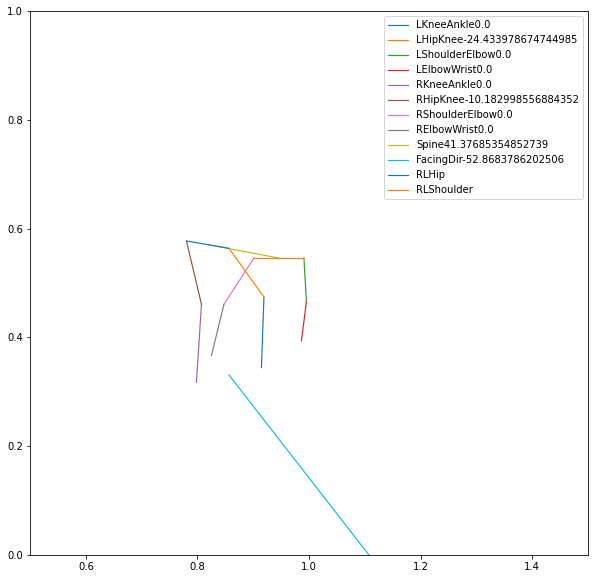

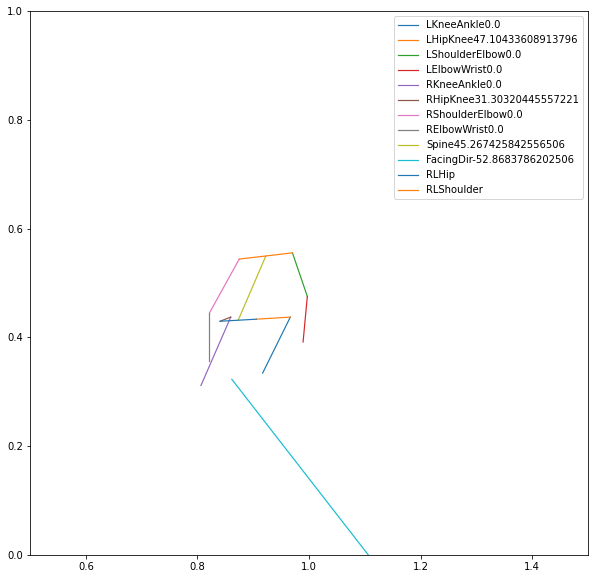

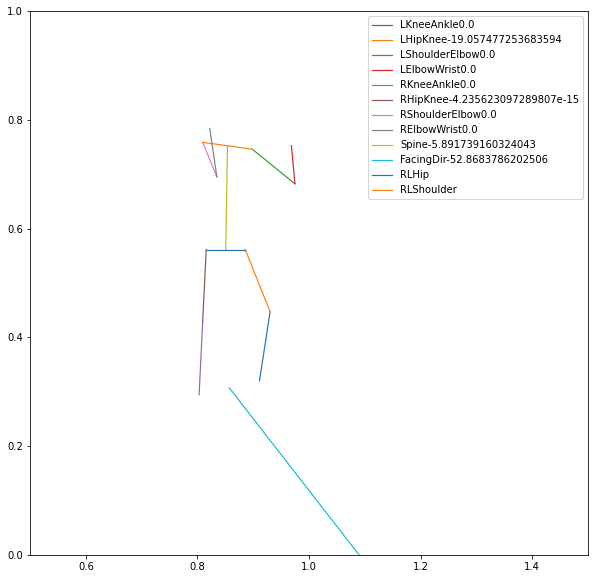

In [99]:
def read_json(pth):
    assert os.path.exists(pth)
    with open(pth) as fp:
        return json.load(fp)

def to_json(obj, pth):
    with open(pth, "w") as fp:
        json.dump(obj, fp)

preds = read_json("output/1RchFn-zZDw-results.json")

for kp in [10, 42, 120]: #10, 42, 120, 210, 240
    Skeleton(preds[kp]['keypoints'], preds).plot(kp, plot_3d=False, angle=0 )

1 [0.9164305792914497, 0.9164305792914497] [0.47254791259765627, 0.34483913845486114] LKneeAnkle0.0
1 [0.8591818067762587, 0.9164305792914497] [0.5606229146321614, 0.47254791259765627] LHipKnee-21.423622248974343
1 [0.9868905809190538, 0.9912943522135417] [0.5474116855197483, 0.4637404123942057] LShoulderElbow0.0
1 [0.9912943522135417, 0.9868905809190538] [0.4637404123942057, 0.3932804107666016] LElbowWrist0.0
1 [0.8063368055555555, 0.7975293477376302] [0.4637404123942057, 0.3184166378445096] RKneeAnkle0.0
1 [0.7843180338541667, 0.8063368055555555] [0.5738341861300998, 0.4637404123942057] RHipKnee-9.04806479961334
1 [0.8988155788845487, 0.8503743489583333] [0.5430079142252604, 0.4593366410997179] RShoulderElbow0.0
1 [0.8503743489583333, 0.8239518059624567] [0.4593366410997179, 0.36245413886176214] RElbowWrist0.0
2 [0.8569799635145399, 2.0642761238882423] [0.33162788814968536, -1.262873909010454] FacingDir-52.8683786202506
3 [0.8591818067762587, 0.7843180338541667] [0.5606229146321614, 

/home/corey/miniconda3/envs/alphapose/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in arccos


TypeError: imshow() missing 1 required positional argument: 'X'

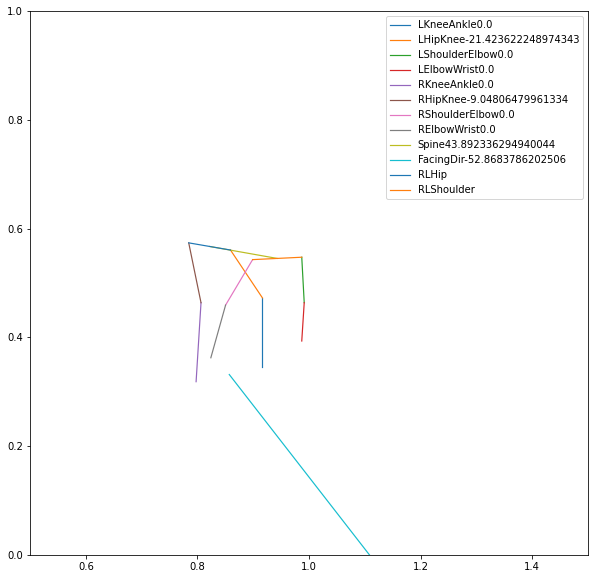

In [100]:
preds = read_json("output/1RchFn-zZDw-results.json")

skel = Skeleton(preds[0]['keypoints'], preds)
skel.plot_animated(plot_3d=False)